In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
diabetes = pd.read_csv('churn.csv')

In [2]:
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [3]:
diabetes.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [4]:
print("Diabetes data set dimensions : {}".format(diabetes.shape))

Diabetes data set dimensions : (768, 9)


In [5]:
diabetes.groupby('Outcome').size()

Outcome
0    500
1    268
dtype: int64

Outcome
0    [[Axes(0.125,0.670278;0.215278x0.209722), Axes...
1    [[Axes(0.125,0.670278;0.215278x0.209722), Axes...
dtype: object

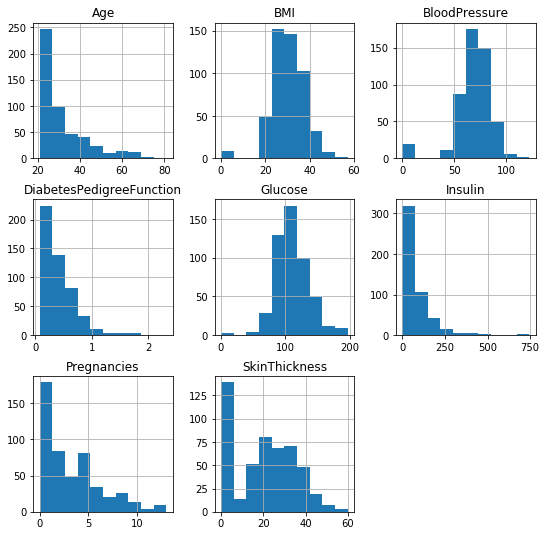

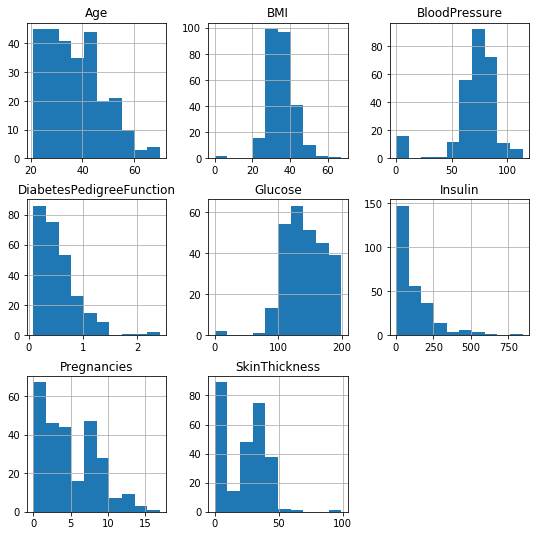

In [6]:
diabetes.groupby('Outcome').hist(figsize=(9, 9))

In [7]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
print("Total : ", diabetes[diabetes.BloodPressure == 0].shape[0])

Total :  35


In [9]:
print(diabetes[diabetes.BloodPressure == 0].groupby('Outcome')['Age'].count())

Outcome
0    19
1    16
Name: Age, dtype: int64


In [10]:
diabetes_mod = diabetes[(diabetes.BloodPressure != 0) & (diabetes.BMI != 0) & (diabetes.Glucose != 0)]
print(diabetes_mod.shape)

(724, 9)


In [11]:
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = diabetes_mod[feature_names]
y = diabetes_mod.Outcome

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = diabetes_mod.Outcome, random_state=0)

In [16]:
names=[]
scores=[]

for name,model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test,y_pred))
    names.append(name)
    
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.729282
1  SVC  0.657459
2   LR  0.767956
3   DT  0.729282
4  GNB  0.734807
5   RF  0.756906
6   GB  0.773481


In [17]:
from sklearn.model_selection import KFold
names = []
scores = []

for name, model in models: 
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  Name     Score
0  KNN  0.719787
1  SVC  0.656279
2   LR  0.766781
3   DT  0.703120
4  GNB  0.757021
5   RF  0.747451
6   GB  0.779186


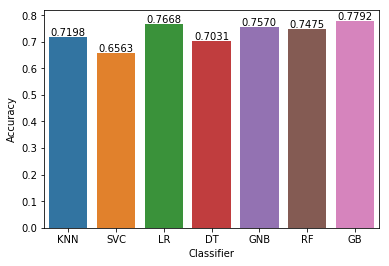

In [19]:
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

In [21]:
from sklearn.feature_selection import RFECV

logregmodel = LogisticRegression()
kfold = KFold(n_splits=10, random_state=10) 
rfecv = RFECV(estimator=logregmodel,step=1,cv=kfold, scoring='accuracy')
rfecv.fit(X, y)

RFECV(cv=KFold(n_splits=10, random_state=10, shuffle=False),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

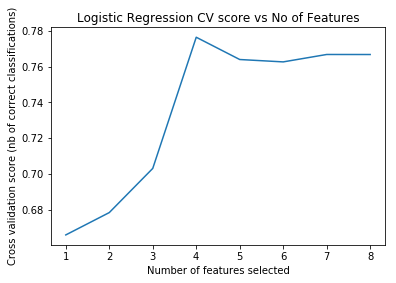

In [22]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [24]:
feature_importance = list(zip(feature_names,rfecv.support_))

In [26]:
new_features=[]

for key,value in enumerate(feature_importance):
    print(key,value)
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

0 ('Pregnancies', True)
1 ('Glucose', True)
2 ('BloodPressure', False)
3 ('SkinThickness', False)
4 ('Insulin', False)
5 ('BMI', True)
6 ('DiabetesPedigreeFunction', True)
7 ('Age', False)
['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']


In [29]:
# Calculate accuracy scores 
X_new = diabetes_mod[new_features]
initial_score = cross_val_score(logregmodel, X, y, cv=kfold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))
fe_score = cross_val_score(logregmodel, X_new, y, cv=kfold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.766780821917808 
Accuracy after Feature Selection : 0.7764459665144596 


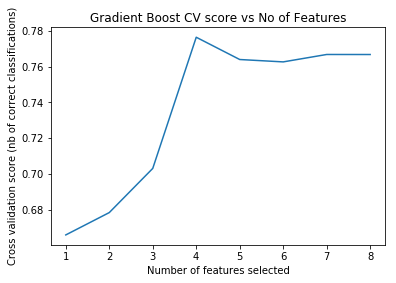

In [30]:
gb_model = GradientBoostingClassifier()
gb_rfecv = RFECV(estimator=logregmodel,step=1,cv=kfold, scoring='accuracy')
gb_rfecv.fit(X, y)
plt.figure()
plt.title('Gradient Boost CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(gb_rfecv.grid_scores_) + 1), gb_rfecv.grid_scores_)
plt.show()

In [33]:
from sklearn.model_selection import GridSearchCV
c_values = list(np.arange(1, 10))
param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]
                
grid = GridSearchCV(LogisticRegression(),param_grid,cv= kfold,scoring='accuracy')
grid.fit(X_new,y)

/Users/pratikaher/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/pratikaher/anaconda/lib/python3.5/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


GridSearchCV(cv=KFold(n_splits=10, random_state=10, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'solver': ['liblinear'], 'multi_class': ['ovr'], 'penalty': ['l1'], 'C': [1, 2, 3, 4, 5, 6, 7, 8, 9]}, {'solver': ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class': ['ovr'], 'penalty': ['l2'], 'C': [1, 2, 3, 4, 5, 6, 7, 8, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [34]:
print(grid.best_params_)
print(grid.best_estimator_)

{'solver': 'liblinear', 'multi_class': 'ovr', 'penalty': 'l2', 'C': 1}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [36]:
log_reg_new = LogisticRegression(C=1,multi_class='ovr',penalty='l2',solver='liblinear')
initial_score = cross_val_score(log_reg_new, X_new, y, cv=kfold, scoring='accuracy').mean()
print("Final accuracy : {} ".format(initial_score))

Final accuracy : 0.7764459665144596 
